### Esercitazione - E03 - Variational Autoencoder

Scarica un dataset di immagini reali, costruisci il tuo variational autoencoder e allenalo per generare immagini!

* Usa il dataset [Oxford 102 Flowers](https://pytorch.org/vision/0.16/generated/torchvision.datasets.Flowers102.html#torchvision.datasets.Flowers102).

* Le immagini di questo dataset in genere hanno shape (3, 128, 128), ma per velocizzare il training puoi usare anche la dimensione (3, 64, 64).

* Costruisci un variational autoencoder basato su reti convoluzionali!

* Nei casi reali, stai attento al bilanciamento tra la loss KL e la loss di ricostruzione! spesso, conviene moltiplicare la KL per un valore piccoo (ad esempio 0.0005) perché i suoi valori sono molto alti rispetto alla loss di ricostruzione.

⚠️ Puoi utilizzare blocchi di codice che abbiamo scritto nei notebook precedenti!

In [94]:
# Colleghiamo Google Drive per salvare risultati, immagini, e checkpoints


In [95]:
import os

import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import Flowers102
import matplotlib.pyplot as plt

In [96]:
# Impostiamo gli hyperparametri
num_epochs = 100
batch_size = 64
learning_rate = 0.005
in_channels = 3
latent_dim = 100
hidden_dims = [32, 64, 128, 256, 512]

In [97]:
# Trasformazioni delle immagini
def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 64, 64)
    return x

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [98]:
# Scarichiamo e prepariamo il dataset
dataset = Flowers102('./data', transform=img_transform, split="train", download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [99]:
if not os.path.exists('/content/drive/MyDrive/RTD-A/Corsi/2023 - ProfessionAI/Colabs/vae_img'):
    os.mkdir('/content/drive/MyDrive/RTD-A/Corsi/2023 - ProfessionAI/Colabs/vae_img')

# Definiamo il modello

class ConvVAE(nn.Module):

    def __init__(self, in_channels, latent_dim, hidden_dims, **kwargs):
        super(ConvVAE, self).__init__()

        self.latent_dim = latent_dim
        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Costruiamo l'encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        # Costruiamo il decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)
        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        result = self.decoder_input(z)
        # print(result.shape)
        result = result.view(-1, 512, 2, 2)
        # print(result.shape)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self, recons, input, mu, log_var):
        """
        Calcola la VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        """
        kld_weight = 0.00025

        # Calcoliamo la loss di ricostruzione
        recons_loss =F.mse_loss(recons, input)

        # Calcoliamo la KL
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        # Calcoliamo la loss completa
        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self, num_samples, current_device, **kwargs):
        """
        Campioniamo dallo spazio latente e ritorniamo l'immagine generate.
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x, **kwargs):
        """
        Data un'immagine, ritorniamo la sua versione ricostruita
        """

        return self.forward(x)[0]

In [100]:
# Definiamo un'istanza del modello, spostiamo su GPU
model = ConvVAE(in_channels=in_channels, latent_dim=latent_dim, hidden_dims=hidden_dims)
if torch.cuda.is_available():
    model.cuda()

# Definiamo l'ottimizzatore
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [101]:
# Alleniamo il nostro VAE
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        if torch.cuda.is_available():
            img = img.cuda()
        optimizer.zero_grad()
        recon_batch, _, mu, logvar = model(img)
        loss = model.loss_function(recon_batch, img, mu, logvar)
        loss["loss"].backward()
        train_loss += loss["loss"].item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(img),
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                loss["loss"].item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(dataloader.dataset)))
    if epoch % 10 == 0:
        save = to_img(recon_batch.cpu().data)
        save_image(save, '/content/drive/MyDrive/RTD-A/Corsi/2023 - ProfessionAI/Colabs/vae_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), '/content/drive/MyDrive/RTD-A/Corsi/2023 - ProfessionAI/Colabs/vae_img/vae.pth')

Train Epoch: 0 [0/1020 (0%)]	Loss: 0.007080
====> Epoch: 0 Average loss: 0.0058
Train Epoch: 1 [0/1020 (0%)]	Loss: 0.012346
====> Epoch: 1 Average loss: 0.0053
Train Epoch: 2 [0/1020 (0%)]	Loss: 0.005022
====> Epoch: 2 Average loss: 0.0046
Train Epoch: 3 [0/1020 (0%)]	Loss: 0.004480
====> Epoch: 3 Average loss: 0.0040
Train Epoch: 4 [0/1020 (0%)]	Loss: 0.003929
====> Epoch: 4 Average loss: 0.0035
Train Epoch: 5 [0/1020 (0%)]	Loss: 0.003769
====> Epoch: 5 Average loss: 0.0034
Train Epoch: 6 [0/1020 (0%)]	Loss: 0.003528
====> Epoch: 6 Average loss: 0.0032
Train Epoch: 7 [0/1020 (0%)]	Loss: 0.003340
====> Epoch: 7 Average loss: 0.0031
Train Epoch: 8 [0/1020 (0%)]	Loss: 0.003047
====> Epoch: 8 Average loss: 0.0030
Train Epoch: 9 [0/1020 (0%)]	Loss: 0.003146
====> Epoch: 9 Average loss: 0.0030
Train Epoch: 10 [0/1020 (0%)]	Loss: 0.003226
====> Epoch: 10 Average loss: 0.0029
Train Epoch: 11 [0/1020 (0%)]	Loss: 0.003002
====> Epoch: 11 Average loss: 0.0028
Train Epoch: 12 [0/1020 (0%)]	Loss: 

torch.Size([3, 64, 64, 3])


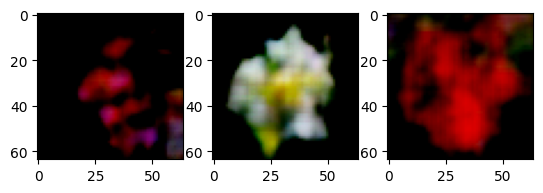

In [108]:
# Generiamo alcuni nuovi campioni
new_sample = model.sample(num_samples=3, current_device="cpu")
new_sample = torch.permute(new_sample.cpu(), (0,2,3,1))
print(new_sample.shape)
plt.subplot(1,3,1)
plt.imshow(new_sample[0].detach().numpy())
plt.subplot(1,3,2)
plt.imshow(new_sample[1].detach().numpy())
plt.subplot(1,3,3)
plt.imshow(new_sample[2].detach().numpy())